Install the required packages:

In [33]:
!pip install pymc matplotlib numpy pandas seaborn

Import packages.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pymc

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Load the data. We have the format:

```python
data[i_VAMP, i_DELAY, i_CYCLE, i_SAMPLE],
```

where:

$\text{VAMP}\in\{3.0V, 3.5V, 4.0V\}$, <br>
$\text{DELAY}\in\{10ns,100ns,1us,10us,100us,1ms,10ms\}$, <br>
$\text{CYCLE}\in\{0,1,2\}$, <br>
$\text{SAMPLE}\in\{0,99\}$ (first 50 is LTP, next 50 is L TD)

In [77]:
# import data from .npy file
VAMP = [3.0, 3.5, 4.0]
DELAY = [10e-9, 100e-9, 1e-6, 10e-6, 100e-6, 1e-3, 10e-3][::-1]
CYCLE = np.arange(3)
PD = ("pot","dep")
SAMPLE = np.arange(50)
TIMESTAMP = np.tile(np.arange(len(CYCLE) * len(PD) * len(SAMPLE)), len(VAMP) * len(DELAY))
_data = np.load("data/0814WL9BL1_device_measurement.npy") * 4 / (2**17)


In [75]:
i_vamp, i_delay, i_cycle, i_pd, i_sample = np.meshgrid(VAMP, DELAY, CYCLE, PD, SAMPLE, indexing="ij")
data = pd.DataFrame({
    "VAMP": i_vamp.flatten(),
    "DELAY": i_delay.flatten(),
    "CYCLE": i_cycle.flatten(),
    "PD": i_pd.flatten(),
    "SAMPLE": i_sample.flatten(),
    "TIMESTAMP": TIMESTAMP,
    "DATA": _data.flatten()
})

(0.0, 0.4)

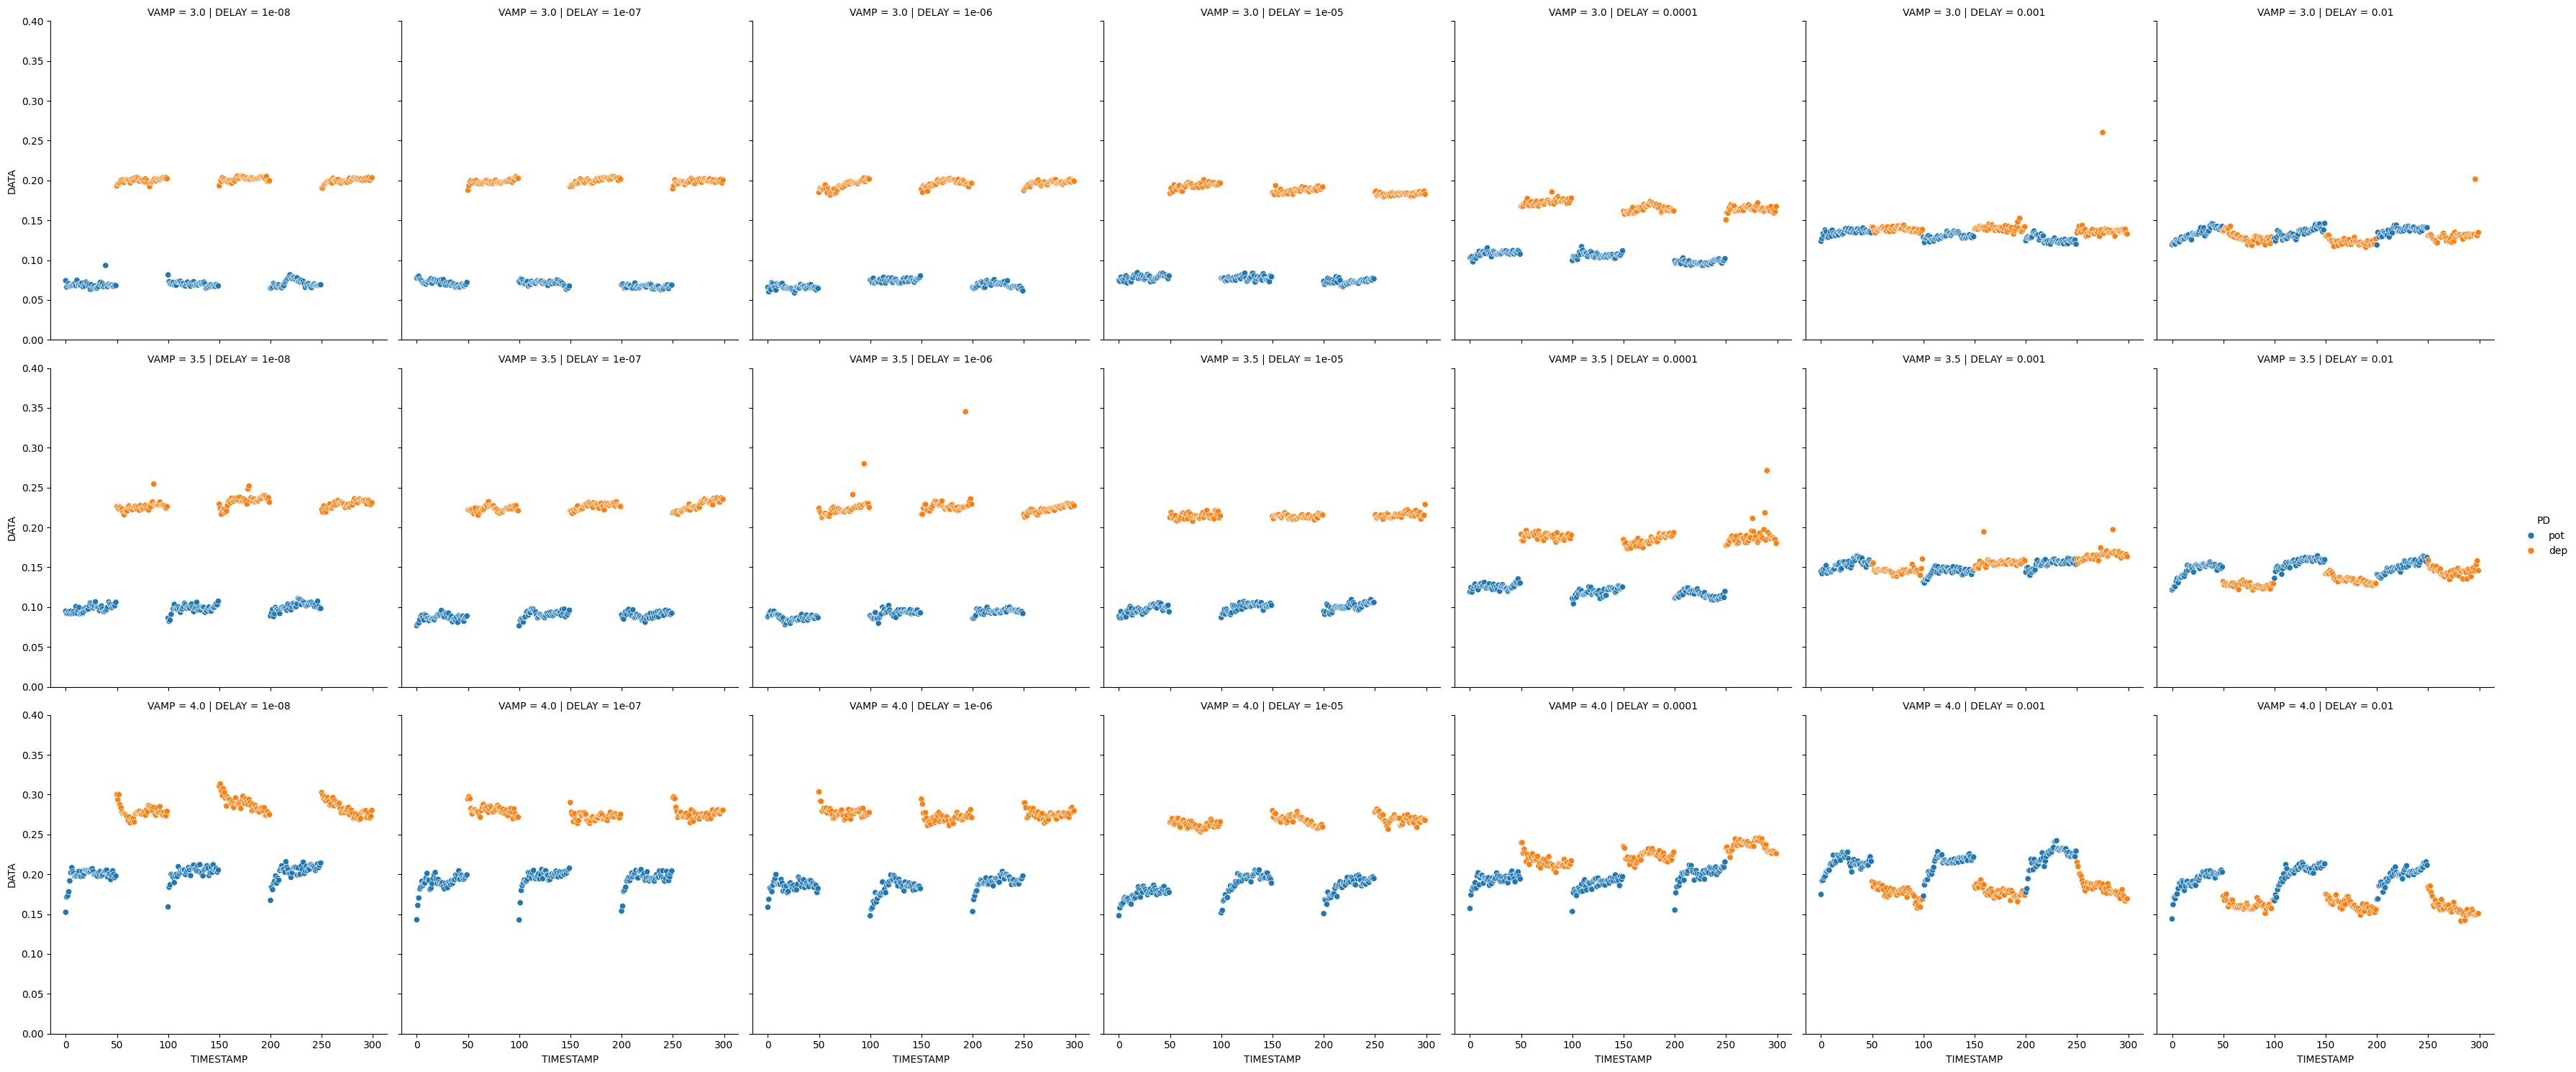

In [76]:
ax = sns.relplot(
    x = "TIMESTAMP",
    y = "DATA",
    hue = "PD",
    col = "DELAY",
    row = "VAMP",
    data=data,

)
ax.axes[0,0].set_ylim(0, 0.4)

In [ ]:
with pymc.Model() as model:
    # Define the prior
    p = pymc.Uniform('p', lower=0, upper=1)
    
    # Define the likelihood
    obs = pymc.Bernoulli('obs', p, observed=np.array([1, 1, 1, 0, 0]))
    
    # Inference
    trace = pymc.sample(1000, tune=500, cores=1)

In [ ]:

class ConsolidatingMemory(object):
    """
    A self-consolidating memory, holding a stable mapping from input to output vectors.
    """

    def __init__(
        self,
        classifier: MultiClassClassifier,
        data: np.ndarray = None,
        labels: np.ndarray = None,
        n_dims_out: int = None,
        n_dims_in: int = None,
        sampler: Callable[[int], np.ndarray] = None,
    ):
        """
        Initialize the memory with the provided data and labels.
        If the data and labels are provided, the memory is trained on the data.
        If the initial_params are provided, the memory is initialized with the provided parameters.

        Args:
            classifier (MultiClassClassifier): The classifier to use inside the memory.
            data (np.ndarray): The input data to train the memory on.
            labels (np.ndarray): The labels for the input data.
            n_dims_out (int): The number of output dimensions.
            n_dims_in (int): The number of input dimensions.
            sampler (Callable[[int],np.ndarray]): A callable that returns the specified number of samples from the data distribution.
        """

        # either data or n_dims_in must be provided
        assert (
            data is not None or n_dims_in is not None
        ), "Either data or n_dims_in must be provided"

        # either labels or n_dims_out must be provided
        assert (
            labels is not None or n_dims_out is not None
        ), "Either labels or n_dims_out must be provided"

        if n_dims_out is None:
            n_dims_out = len(np.unique(labels))
        self.n_dims_out = n_dims_out

        if n_dims_in is None:
            n_dims_in = data.shape[1]
        self.n_dims_in = n_dims_in

        self.classifier = classifier
        self.sampler = sampler

        # train on the provided data
        if data is not None and labels is not None:
            self.classifier.train(data, labels)

    def store(self, data: np.ndarray, labels: np.ndarray):

        while True:
            # see if any values are misclassified
            pred = self.classifier.predict(data)

            # if all values are correctly classified, break
            if np.all(pred == labels):
                break

            # train the classifier on the new data
            self.classifier.train(data, labels)

    def retrieve(self, data: np.ndarray):
        return self.classifier.predict(data)

    def consolidate(self, data: np.ndarray = None, n_samples: int = None):
        """
        Consolidate the memory by generating in-class samples and re-training the classifier.

        Args:
            data (np.ndarray): The data to generate in-class samples from.
            n_samples (int): The number of in-class samples to generate.
                If data is provided and n_samples is not None, take the samples from the data (random draw with replacement).
        """
        # generate in-class samples
        if data is not None:
            samples = data[np.random.choice(len(data), n_samples), ...]
        elif n_samples is not None and self.sampler is not None:
            samples = self.sampler(n_samples)
        else:
            raise ValueError(
                "Either data or a sampler and number of samples must be provided to generate in-class samples."
            )

        # impute the labels
        labels = self.classifier.predict(samples)

        # train the classifier with the new data and imputed labels
        self.train(data, labels)

# Newer measurements from Samira

Text(0.5, 0, 'Cell')

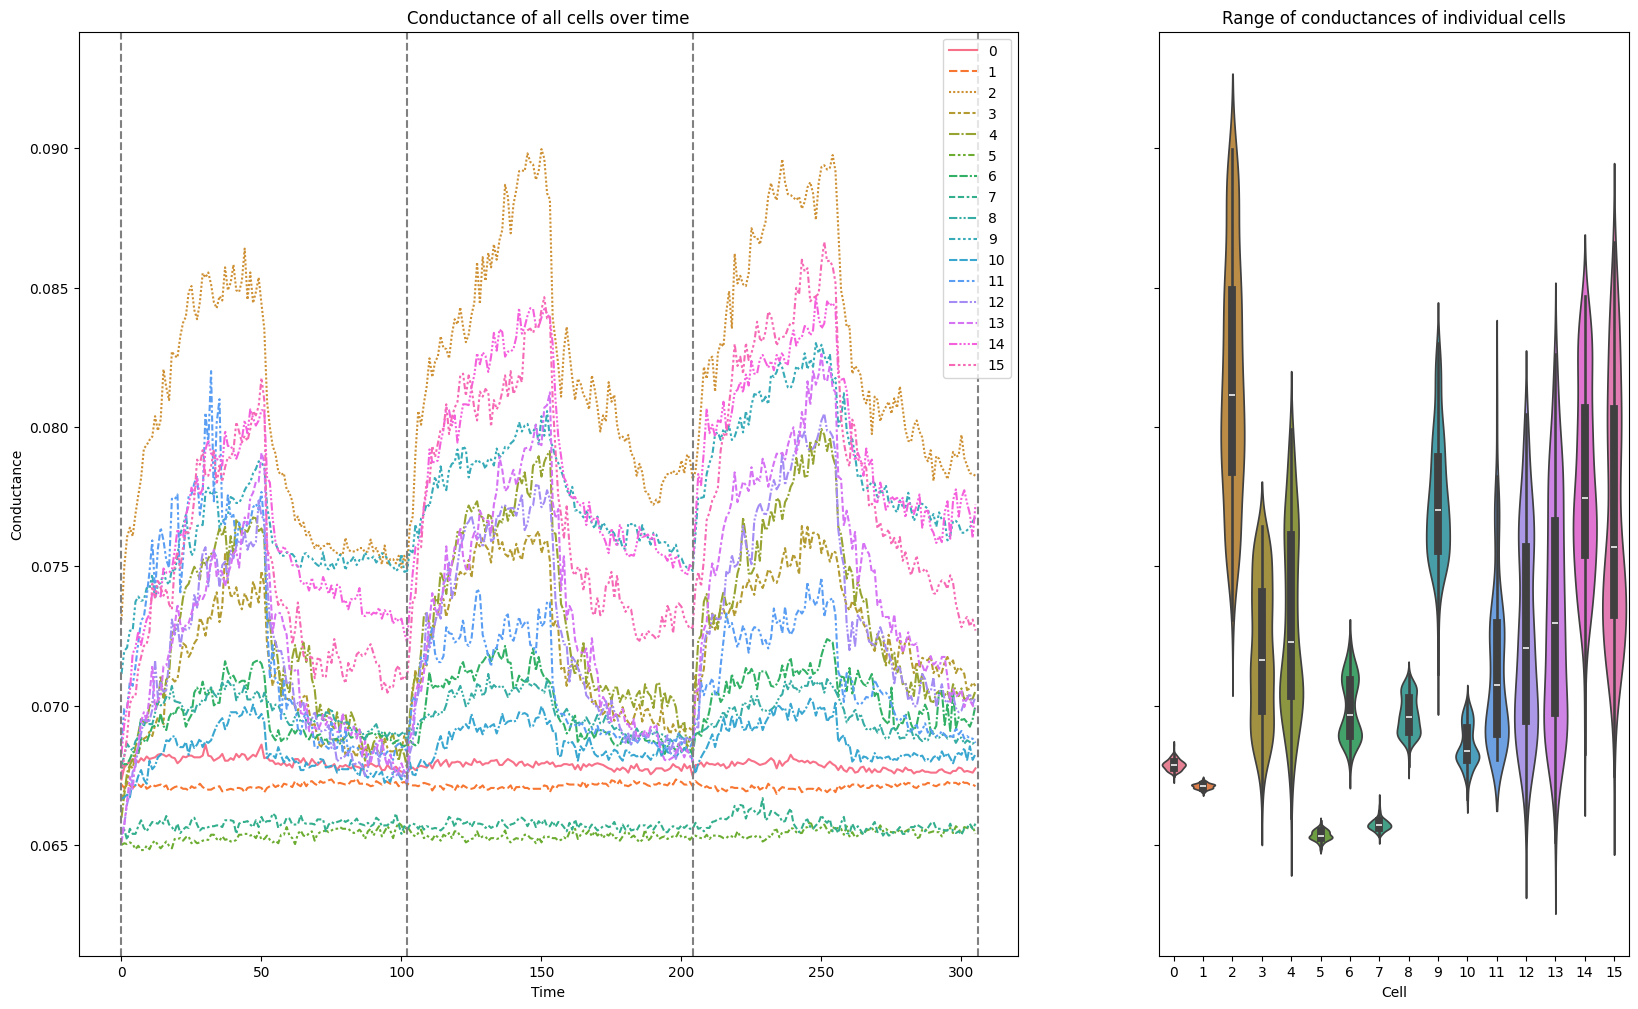

In [34]:
import seaborn as sns

data_raw = np.load("../data/all_programming_WL_1-16_BL_1_vp_read_2.3V_read_dur_100us_Amp_3.5V_pulse_dur_1ms_STRUCTURE(WL,BL,CYCLE,DATA).npy")
data = data_raw[:,0,:,:].reshape((16, -1)).T

fig,ax = plt.subplots(1, 2, figsize=(20,12), sharey=True, width_ratios=[2, 1])
sns.lineplot(data=data, ax=ax[0])
sns.violinplot(data=data, ax=ax[1])
for x in np.arange(4)*data_raw.shape[3]:
    ax[0].axvline(x, color="gray", linestyle="--")

ax[0].set_title("Conductance of all cells over time")
ax[0].set_ylabel("Conductance")
ax[0].set_xlabel("Time")

ax[1].set_title("Range of conductances of individual cells")
ax[1].set_xlabel("Cell")

In [29]:
data.shape

(306, 16)